# Example working with airborne imaging spectroscopy data over northern California


data 
## 
        doi:10.5066/F7Q52NZ1



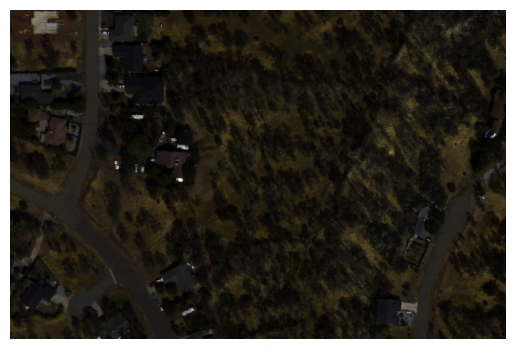

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your hyperspectral raster
raster_path = '../tests/data/ca-test'

# Open the raster file
with rasterio.open(raster_path) as src:
    red = src.read(16)
    green = src.read(13)
    blue = src.read(5)
    array = src.read()

# Normalize the values for display
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

SLIC can be applied on a smaller array using PCA, and can give fairly homogeneous regions that can be used for the HRDSDC method

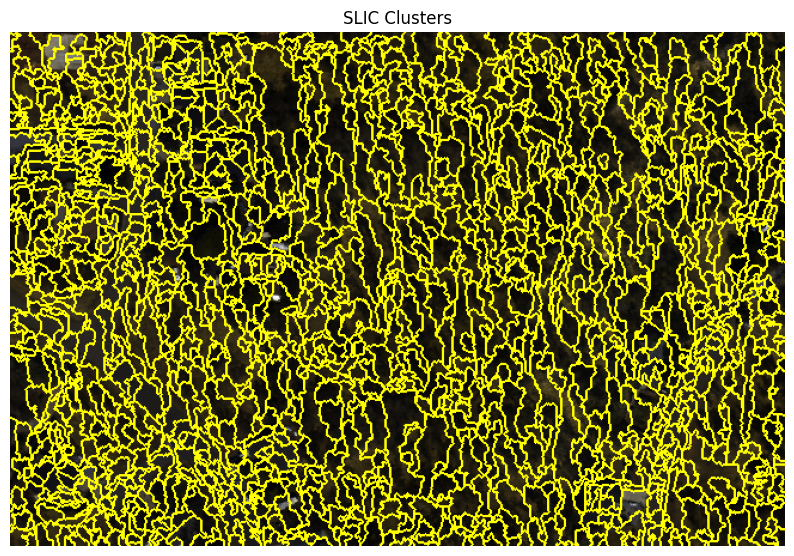

In [3]:
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA

# Open the raster file
with rasterio.open(raster_path) as src:
    array = src.read()

# Rearrange to (rows, cols, bands) for segmentation
array = np.moveaxis(array, 0, -1)

# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
segments = slic(array_pca, 
                n_segments=5000, 
                compactness=0.1)


plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(rgb_image, segments))
plt.title("SLIC Clusters")
plt.axis("off")
plt.show()

This is not a perfect science here, and defining which compactness and n_segments will take iterations and depend on the application.

With these parameters, we can compute the image-wide SNR.

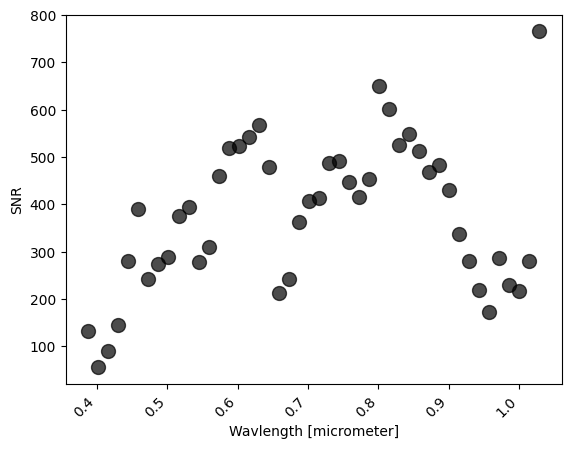

In [4]:
import hyperquest

# get wavelengths
wavelengths = hyperquest.read_center_wavelengths(raster_path)

# compute HRDSDC
snr = hyperquest.hrdsdc(raster_path, n_segments=5000, 
                        compactness=0.1, n_pca=3, ncpus=3)

plt.scatter(wavelengths, snr, color='black', s=100, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Wavlength [micrometer]')
plt.ylabel('SNR')
plt.show()

You could also test several combinations in a loop to test how the output changes

C:\Users\kenne\OneDrive\Documents\snr\hyperquest\snr.py:201: RuntimeWarning: Mean of empty slice
  mu_valid = np.nanmean(local_mu[:, 1:-1], axis=0)
C:\Users\kenne\OneDrive\Documents\snr\hyperquest\snr.py:202: RuntimeWarning: Mean of empty slice
  sigma_valid = np.nanmean(local_sigma[:, 1:-1], axis=0)


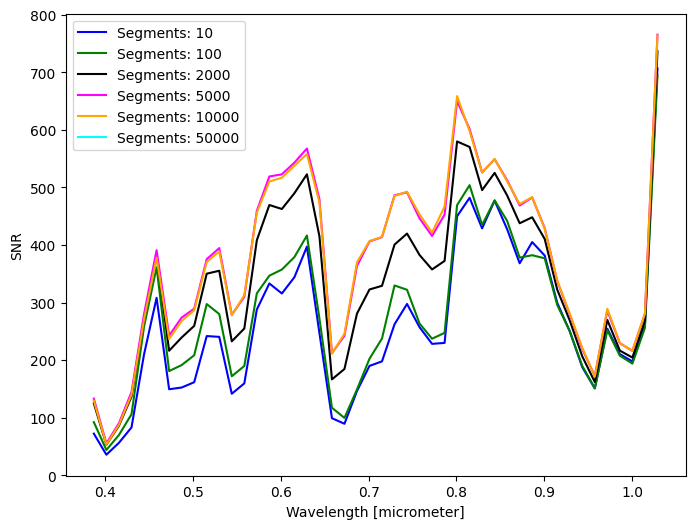

In [5]:
# param list
params_list = [
    {'n_segments': 10, 'compactness': 0.1, 'n_pca': 3, 'ncpus': 3},
    {'n_segments': 100, 'compactness': 0.1, 'n_pca': 3, 'ncpus': 3},
    {'n_segments': 2000, 'compactness': 0.1, 'n_pca': 3, 'ncpus': 3},
    {'n_segments': 5000, 'compactness': 0.1, 'n_pca': 3, 'ncpus': 3},
    {'n_segments': 10000, 'compactness': 0.1, 'n_pca': 3, 'ncpus': 3},
    {'n_segments': 50000, 'compactness': 0.1, 'n_pca': 3, 'ncpus': 3},
]

# set colors
colors = ['blue', 'green', 'black', 'magenta', 'orange', 'cyan']

plt.figure(figsize=(8, 6))
for params, color in zip(params_list, colors):
    snr = hyperquest.hrdsdc(raster_path, **params)
    plt.plot(wavelengths, snr, color=color, label=f"Segments: {params['n_segments']}")

# Add labels and title
plt.xlabel('Wavelength [micrometer]')
plt.ylabel('SNR')
plt.legend()
plt.show()


Increasing the segmentation too much will reduce the amount of pixels and eventually will not have enough data for MLR (e.g., there is nothing above for nsegments=50,000). There is a balance to it that deserves a closer look.

In the following paper, they did a method similar to HRDSDC but also included neighborhood pixel in their MLR. They also extracted only the middle portions of the segmentation to reduce edge effects. 

See here : https://doi.org/10.1016/j.rse.2021.112499 .
